## BoosterFuels Analytics Case: Labor Optimization
**Magnus Skonberg | June 3rd 2021**

The purpose of this case study was to offer labor optimization recommendations based on Service Professional activity logs and, more specifically, to answer the following questions:

* What patterns do you extract from the dataset?
* What learnings can you draw?
* What suggestions do you have to improve efficiency of Service Professionals at Booster?

### Data

We explore a dataset representing the activity log of Service Professionals in two Booster regions, from Aug 25 to Sept 16.

### Approach

My appoach in attempting to answer these questions was to: 

1. **EDA**: perform initial and high level EDA to gain a better understand of our data.
2. **Data Preparation**: using the insights gained and provided handout, assign events, filter for proper sequencing and then derive states from events (with elapsed times).
3. **Visualization and Interpretation**: explore time allocation based on region, driver, and state.
4. **Conclusion**: summarize findings and answer the questions outlined above.


## 1. EDA

As an essential first step, we setup the environment from which we intend to analyze our data. We elect our IDE (Jupyter in this case), import libraries essential for data exploration, manipulation, and visualization, and then read in our data. *Note: I elected Jupyter to document the process along the way (ie. embedding code and visualizations).*

During this exploratory data analysis (EDA) process we perform our initial EDA and a high level EDA prior to preparing our data for visualization and interpretation.

### Initial EDA

In [2]:
#Import essential libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from datetime import datetime
from tabulate import tabulate

#Load in data
data = pd.read_csv("Final Data presentation.csv") #place csv file in working directory

#Initial EDA
#data.head() #first 5 observations
#data.shape #observations x variables
#data.info()
data.nunique() #number of unique values per variable


_id                   4494
region                   2
driver                  19
driverShiftId          189
action                   8
actionType               2
capturedAt            4417
source                   5
tanker                  18
fleetAccount            67
totalFuelDispensed     472
terminal                 4
yard                     2
totalFills              81
dtype: int64

We view the first 5 observations, shape, and info and extend that:

* our data is **4494 x 14**,
* we're dealing with **2 numeric variables** and **12 string variables**,
* variable conversion may be necessary (ie. capturedAt to datetime and region to categoric),
* half our data is not missing any values, while the other half is missing a significant portion. Thus, dealing with NA values / properly filtering our data prior to later visualizations will likely prove an essential step.

And then proceed to interpret our output of unique values as indication that:

* there are **2 regions, 19 drivers, 189 shifts worked, 4417 logged times (67 missing), 18 tankers, 67 accounts, 4 terminals, and 2 yards**,
* fuel was dispensed a total of 472 times with 81 different combinations of vehicles touched, and
* while our provided PDF lists 4 sources, our dataset has 5 (BOA being the "undocumented" variable).

To visualize the presence of missing values we make use of the missingno package:

<AxesSubplot:>

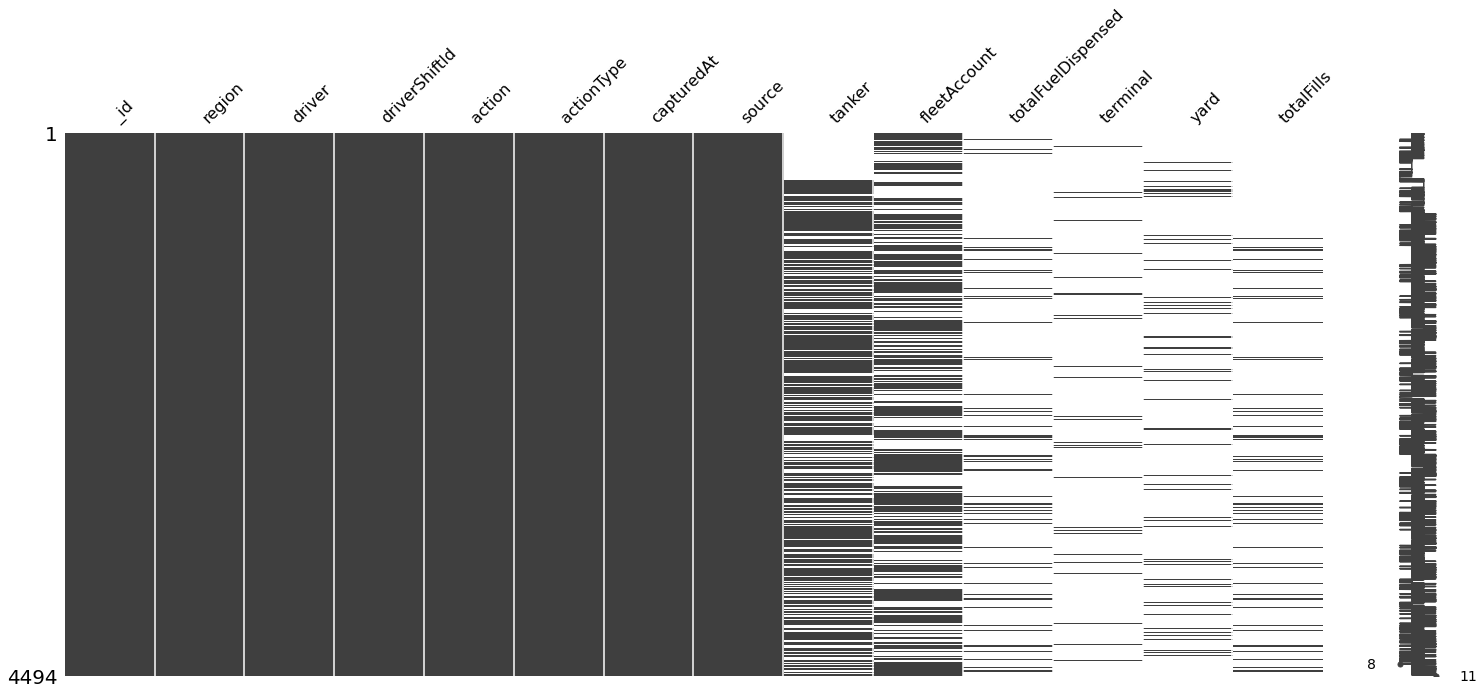

In [3]:
msno.matrix(data) #missing data matrix

The above visualization confirms that half our variables are not missing data while simultaneously highlighting the pattern / presence of missing data per observation (1-4494 on the lefthand side) for remaining variables.

This visualization shows that the missing data appears to be at random, and thus dropping NULL value observations is a bad idea. It would lead to our losing the majority, if not all, of our data. On this point, we can interpret the values at the bottom right of the visualization as indication that all observations have 8-11 valid values and 3-6 missing values. This indicates that for certain variables (ie. source-action pairings) other variables will have missing values and for others they will be populated. **The above plot confirms our earlier read that filtering / subsetting data will likely be required to better explore and visualize.**

### High Level EDA

In this section, we seek to further clarify data preparation steps and assumptions. We'll start by answering higher-level questions to then narrow in (later) and answer datetime-specific questions. We set out to answer (for each region):

* What drivers, and how many, work in each region?
* How many tankers are in use?
* How many shifts were worked?
* How much fuel was dispensed?
* How many accounts were serviced?
* How many vehicles were touched? 

In [4]:
#Prepare dataset
df = data.drop(['_id'], axis=1) #drop _id
df['capturedAt'] = pd.to_datetime(df['capturedAt']) #convert capturedAt to datetime

#subset data based on these variables
DAL = df[df['region'] == 'Dallas Fort Worth']
AUS = df[df['region'] == 'Austin']

#list unique drivers names and total count
#DAL['driver'].nunique() #10 drivers
DAL['driver'].unique()
#AUS['driver'].nunique() #9 drivers
AUS['driver'].unique()

#list unique tankers and total count
#DAL['tanker'].nunique() #11 tankers
DAL['tanker'].unique()
#AUS['tanker'].nunique() #7 tankers
AUS['tanker'].unique()
#list unique driver shifts and count per driver

#list total shifts per region
DAL['driverShiftId'].nunique() #104 shifts
AUS['driverShiftId'].nunique() #85 shifts

#list total amount of fuel dispensed, vehicles touched, and accounts serviced:
DAL['totalFuelDispensed'].sum() #52527.072
DAL['totalFills'].sum() #4052
DAL['fleetAccount'].nunique() #64

AUS['totalFuelDispensed'].sum() #56985.219
AUS['totalFills'].sum() #6740
AUS['fleetAccount'].nunique() #3

print("High level EDA complete.")

High level EDA complete.


From above we noted that Dallas Fort Worth has 10 drivers, 11 tankers and 104 shifts worked while Austin has 9 drivers, 7 tankers and 85 shifts worked. *Tanker 11 is spelt in French (Onze) and names are fictional.*

With more drivers, tankers, and shifts, we might assume that Dallas had a larger service area and thus delivered more fuel, but when we explored further we found the opposite: **Dallas Fort Worth pumped ~52527 gallons** of gasoline to 4052 vehicles across 64 fleetAccounts compared to **Austin's ~56985 gallons** of gasoline to 6740 vehicles across just 3 fleetAccounts. **From this we might extend that Austin outperformed Dallas.**

Before moving on to the preparation of our data, we visualize event counts:

In [5]:
#create output table as list of lists (using values from above):
table = [['Source','Action','Start Time Count','End Time Count'], 
         ['DEPUTY','LUNCH',42,42], 
         ['','SHIFT',172,130],
         ['FLEETIO','PRE_TRIP',171,177],
         ['','POST_TRIP',289,291],
         ['PANGOLIER','FLEET',794,772],
         ['','TERMINAL',116,118],
         ['','YARD',191,198],
         ['WILSON','DELIVERY',508,478],
         ['BOA','DELIVERY',0,5]]

print(tabulate(table))

---------  ---------  ----------------  --------------
Source     Action     Start Time Count  End Time Count
DEPUTY     LUNCH      42                42
           SHIFT      172               130
FLEETIO    PRE_TRIP   171               177
           POST_TRIP  289               291
PANGOLIER  FLEET      794               772
           TERMINAL   116               118
           YARD       191               198
WILSON     DELIVERY   508               478
BOA        DELIVERY   0                 5
---------  ---------  ----------------  --------------


From the above table we can see that:

* we might relabel BOA to WILSON for simpler processing,
* Source-Action pairings provide insight regarding SPs allocation of time (ie. DEPUTY-LUNCH, WILSON-DELIVERY, etc.),
* there are many discrepancies between logged entries and shifts (ie. only 42 lunches taken on 185 shifts?), and
* when operating on / interpreting datetimes, we should only consider complete observations (ie. `driverShiftId`s with a START and END time),
* more times entering/exiting the yard than shifts either means that data was mis-logged or that during a shift certain drivers returned to the yard during their shift and at the end of the shift. **Thus, time was taken from the day to return to refuel.** 

*Note: the code that generated the values for populating the above table is available in the Appendix.*

## Data Preparation

Using the insights gained and provided handout, we proceed to event assignment, filtering for proper sequencing, and then deriving states from events (including elapsed times).

In [6]:
#Data pre-processing: drop and convert variables - COMPLETED earlier
#df = data.drop(['_id'], axis=1) #drop _id
#df['capturedAt'] = pd.to_datetime(df['capturedAt']) #convert to datetime

#set source BOA to WILSON
df2 = df.replace('BOA', 'WILSON')

#sort df based on driverShiftId and datetime
df2 = df.sort_values(["driverShiftId", "capturedAt"], ascending = (True, True))

Within our dataframe, sources set as BOA were relabelled WILSON and data was sorted based on driverShiftId and timing (earlier events ahead of later events).

### Event Assignment

I then consulted the High level process flow provided in the writeup and devised the following event delineations (formatted as Event : Source | Action | ActionType):

* A: Deputy | Shift | Start
* B: Fleetio | Pre Trip | Start
* C: Fleetio | Pre Trip | End 
* D: Pangolier | Yard | End 
* E: Pangolier | Fleet | Start
* F: Wilson | Delivery | Start
* G: Wilson | Delivery | End
* H: Pangolier | Fleet | End
* I: Pangolier | Terminal | Start
* J: Pangolier | Terminal | End
* K: Deputy | Lunch | Start
* L: Deputy | Lunch | End
* M: Pangolier | Yard | Start
* N: Fleetio | Post Trip | Start
* O: Fleetio | Post Trip | End
* P: Deputy | Shift | End

With these delineations in mind, we proceed to assign event values based on Source | Action | ActionType labels and plot resulting event counts:


<AxesSubplot:>

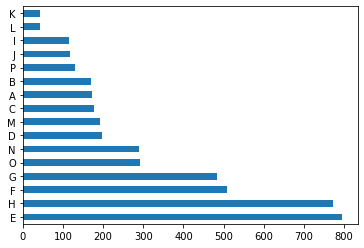

In [7]:
#---Event Assignment---#

# create a list of our conditions
conditions = [ 
    (df2['action']=='SHIFT') & (df2['actionType']=='START'),
    (df2['action']=='PRE_TRIP') & (df2['actionType']=='START'),
    (df2['action']=='PRE_TRIP') & (df2['actionType']=='END'),
    (df2['action']=='YARD') & (df2['actionType']=='END'),
    (df2['action']=='FLEET') & (df2['actionType']=='START'),
    (df2['action']=='DELIVERY') & (df2['actionType']=='START'),
    (df2['action']=='DELIVERY') & (df2['actionType']=='END'),
    (df2['action']=='FLEET') & (df2['actionType']=='END'),
    (df2['action']=='TERMINAL') & (df2['actionType']=='START'),
    (df2['action']=='TERMINAL') & (df2['actionType']=='END'),
    (df2['action']=='LUNCH') & (df2['actionType']=='START'),
    (df2['action']=='LUNCH') & (df2['actionType']=='END'),
    (df2['action']=='YARD') & (df2['actionType']=='START'),
    (df2['action']=='POST_TRIP') & (df2['actionType']=='START'),
    (df2['action']=='POST_TRIP') & (df2['actionType']=='END'),
    (df2['action']=='SHIFT') & (df2['actionType']=='END')
]

values = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P'] #strings for later concatenation

# create a new state column and use np.select to assign values to it using our lists as arguments
df2['event']= np.select(conditions, values)
df2.event.value_counts().plot(kind='barh') #verify counts per event

From the above plot we observe that events associated with Lunch are least common (K,L) and events associated with Fleet Delivery (E,H) are most common.

## Sequence Filtering

With this in mind, we proceed to filtering our data for proper sequencing. Our assumption being that SPs that properly clock in / clock out and log their pre and post trip inspections are the most likely to have precise time records from which we can visualize and interpret our SP's allocation of time.

Pertinent driverShiftId's and sequences are output below:

In [8]:
#---Pattern Assignment---#

##create sequence (concatenate states) for every unique driverShiftId
dSI_list = list(df2['driverShiftId'].unique()) #list unique driverShiftIds
seq = [] #hold corresponding sequences

#iterate thru all entries of df2 for this driverShiftId
for x in dSI_list:
    x_df = df2[df2['driverShiftId'] == x] #subset based on this particular id
    seq.append(' '.join(x_df["event"])) #concatenate corresponding State column

#len(seq) #189 #verify proper sequencing

#---Pattern Recognition---#

#create df with driverShiftId and State Sequence
PR_df = pd.DataFrame({'driverShiftId': dSI_list,'Event Sequence': seq})

#attempt to sift for complete sequences:
def comp_seq(s):
    state = 0 #initialize
    complete = False
    
    for c in s: #interpret character by character
        if state == 0:
            if c == 'A':
                state = 1
            else:
                break # exit loop / incorrect sequence
        elif state == 1:
            if c == ' ':
                state = 1 #do nothing, continue iterating through string
            elif c == 'B':
                state = 2
            else:
                break # exit loop / incorrect sequence
        elif state == 2:
            if c == ' ':
                state = 2 #do nothing, continue iterating through string
            elif c == 'C':
                state = 3
            else:
                break # exit loop / incorrect sequence
        elif state == 3:
            if c == ' ':
                state = 3 #do nothing, continue iterating through string
            elif c == 'D':
                state = 4
            else:
                break # exit loop / incorrect sequence
        elif state == 4:
            if c in [' ', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L']:
                state = 4 #do nothing, continue iterating through string
            elif c == 'M':
                state = 5
            else:
                break # exit loop / incorrect sequence
        elif state == 5:
            if c == ' ':
                state = 5 #do nothing, continue iterating through string
            elif c == 'N':
                state = 6
            else:
                break # exit loop / incorrect sequence
        elif state == 6:
            if c == ' ':
                state = 6 #do nothing, continue iterating through string
            elif c == 'O':
                state = 7
            else:
                break # exit loop / incorrect sequence
        elif state == 7:
            if c == ' ':
                state = 7 #do nothing, continue iterating through string
            elif c == 'N':
                state = 8
            else:
                break # exit loop / incorrect sequence
        elif state == 8:
            if c == ' ':
                state = 8 #do nothing, continue iterating through string
            elif c == 'O':
                state = 9
            else:
                break # exit loop / incorrect sequence
        elif state == 9:
            if c == ' ':
                state = 9 #do nothing, continue iterating through string
            elif c == 'P':
                complete = True #as (assumed) last char this should be the end of the sequence / for loop as well
            else:
                break # exit loop / incorrect sequence
    
    return complete
            
#Test function call 
#PR_df['Event Sequence'][0] #'G H E F G H E F G N O N P O'
#comp_seq(PR_df['Event Sequence'][0]) #False - Correct
#PR_df['Event Sequence'][14] #'A B C D E H E H E H I J E H M N O N O P'
#comp_seq(PR_df['Event Sequence'][14]) #True - Correct

#Add column to hold whether the entries sequence was in order
PR_df['Complete'] = [comp_seq(entry) for entry in PR_df['Event Sequence']]

#Create list of driverShiftIds where Complete = True
rslt_df = PR_df[PR_df['Complete'] == True]
#print(len(rslt_df)) #23/189
rslt_df

,driverShiftId,Event Sequence,Complete
14,5f4704cc2e88a7001230387c,A B C D E H E H E H I J E H M N O N O P,True
27,5f4858b4f49554001363bc26,A B C D I J E H E H I J M N O N O P,True
30,5f4999ce2404c6001212d231,A B C D E H E H E H M N O N O P,True
41,5f4af8f0786b0800122ea779,A B C D E H E H M N O N O P,True
52,5f4c4d702404c6001212de79,A B C D I J K L E H E H M N O N O P,True
72,5f5030d84a89d40012bf41b6,A B C D E F G H E F G H E F G H E F H E H G M ...,True
77,5f503f5e680c490012bb19e2,A B C D F E H I J E G H M N O N O P,True
78,5f50407a4a89d40012bf471d,A B C D E F G H E F G H M N O N O P,True
79,5f5043184a89d40012bf4759,A B C D I J E F H G M N O N O P,True
85,5f5190712ede7d00127bb02b,A B C D F E H I J E G H M N O N O P,True


From the 189 shifts registered in our logs, **only 23 shifts meet the condition** of having a proper entry (clock in, pre inspection, exit yard) and exit sequence (enter yard, post inspection 2x, clock out).

We proceed only with entries with a proper sequence in order to explore the most accurate of data. The assumption being that if the start and end sequences were properly entered by the SP, the in-between sequence of events is more likely to be accurate and we won't have to guess elapsed time. Rather we'll be able to, with more confidence, use our data as it was entered.

## State Derivation

With our dataframe properly filtered for *only* accurate SP entries, we proceed to use events to trigger state transitions and calculate the time spent in each state for our SP shifts of interest:

In [9]:
#Use events (ie. DEPUTY-SHIFT-START) to signal state chg / log time in each state

##Filter for complete shifts and unique driverShiftIds
comp_shifts = list(rslt_df['driverShiftId'])
filtered_df = df2[df2.driverShiftId.isin(comp_shifts)]
#print(len(filtered_df)) #484 entries
dSI_list2 = list(filtered_df['driverShiftId'].unique()) #list unique driverShiftIds

##Initialize state elapsed time data storage
shift_elapsed = []
pre_elapsed = []
transit_elapsed = []
fleet_elapsed = []
delivery_elapsed = []
terminal_elapsed = []
lunch_elapsed = []
yard_elapsed = []
post_elapsed = []

#Iterate thru all entries of filtered_df for this driverShiftId
for x2 in dSI_list2:
    x_df2 = filtered_df[filtered_df['driverShiftId'] == x2] #subset based on proper ids
    
    #shift elapsed time
    a = x_df2[x_df2['event'] == 'A'].capturedAt
    p = x_df2[x_df2['event'] == 'P'].capturedAt
    shift = p.values - a.values
    shift_elapsed.append(int(shift/1000000000)) #cast timedelta to integer representative of minutes
    
    #pre inspection elapsed time
    b = x_df2[x_df2['event'] == 'B'].capturedAt
    c = x_df2[x_df2['event'] == 'C'].capturedAt
    pre = c.values - b.values
    pre_elapsed.append(int(pre/1000000000))
    
    #fleet elapsed time
    e = x_df2[x_df2['event'] == 'E'].capturedAt
    h = x_df2[x_df2['event'] == 'H'].capturedAt
    fleet = h.values - e.values
    #fleet_dict[x2] = [int(entry/1000000000) for entry in fleet]
    for entry in fleet:
        fleet_elapsed.append(int(abs(entry)/1000000000))
    
    #delivery elapsed time
    f = x_df2[x_df2['event'] == 'F'].capturedAt
    g = x_df2[x_df2['event'] == 'G'].capturedAt
    delivery = g.values - f.values
    #delivery_dict[x2] = [int(entry/1000000000) for entry in delivery]
    for entry in delivery:
        delivery_elapsed.append(int(entry/1000000000))
    
    #terminal elapsed time
    i = x_df2[x_df2['event'] == 'I'].capturedAt
    j = x_df2[x_df2['event'] == 'J'].capturedAt
    terminal = j.values - i.values
    #terminal_dict[x2] = [int(entry/1000000000) for entry in terminal]
    for entry in terminal:
        terminal_elapsed.append(int(entry/1000000000))
    
    #lunch elapsed time
    k = x_df2[x_df2['event'] == 'K'].capturedAt
    l = x_df2[x_df2['event'] == 'L'].capturedAt
    lunch = l.values - k.values
    #lunch_dict[x2] = [int(entry/1000000000) for entry in lunch]
    for entry in lunch:
        lunch_elapsed.append(int(entry/1000000000))
    
    #yard elapsed time
    m = x_df2[x_df2['event'] == 'M'].capturedAt
    n = x_df2[x_df2['event'] == 'N'].capturedAt
    yard = n.values - m.values
    #yard_dict[x2] = [int(entry/1000000000) for entry in yard]
    for entry in yard:
        yard_elapsed.append(int(entry/1000000000))
        
    #post trip inspection elapsed time
    o = x_df2[x_df2['event'] == 'O'].capturedAt
    post = o.values - n.values
    #post_dict[x2] = [int(entry/1000000000) for entry in post]
    for entry in post:
        post_elapsed.append(int(entry/1000000000))
    
    #transit elapsed time - dealt with via assumptions (ie. "remainder state")
    ##compile event-timestamps for transit entry
    #d = x_df2[x_df2['event'] == 'D'].capturedAt
    #entry = d.append(h)
    #entry = entry.append(j)
    #entry = entry.append(l)
    #entry = sorted(entry)
    #entry = pd.Series(entry)
    ##compile event-timestamps for transit exit
    #exit = e.append(i)
    #exit = exit.append(k)
    #exit = exit.append(m)
    #exit = sorted(exit)
    #exit = pd.Series(exit)

print('Elapsed times calculated.')


#Calculate total time in each state

##1. total time spent by SPs in each state
total_shift = round(sum(shift_elapsed) / 3600,2)
#total_shifts #250 hrs across 30 shifts

total_pre = round(sum(pre_elapsed) / 3600,2)
#total_pre #5.25

total_fleet = round(sum(fleet_elapsed) / 3600,2)
#total_fleet #135.7

total_delivery = round(sum(delivery_elapsed) / 3600, 2)
#total_delivery #175.72 #HOW/WHY would this be more than fleet?

total_terminal = round(sum(terminal_elapsed) / 3600, 2)
#total_terminal #7.51

total_lunch = round(sum(lunch_elapsed) / 3600, 2)
#total_lunch #1.02 - 1 entry

total_yard = round(sum(yard_elapsed) / 3600, 2)
#total_yard #8.31

total_post = round(sum(post_elapsed) / 3600, 2)
#total_post #3.18

total_transit = total_shift - (total_pre + total_fleet + total_terminal + total_lunch + total_yard + total_post)
#total_transit #89.15

print("State totals tallied.")

Elapsed times calculated.
State totals tallied.


With elapsed time calculated and state (totals) tallied, we proceed to the visualization and interpretation of our data. But first, we familiarize ourselves with our over-arching assumptions.

### Assumptions

1. **Sequencing matters.** SPs that properly clock in / clock out and log their pre and post trip inspections provide the most precise representation of time allocation. I leaned on the idea that data was entered in sequence (once we'd filtered for the most precise entries) in deriving our events and states.
2. **State assignment is accurate.** The manner in which events were used to derive states and elapsed time provides an accurate representation of actual SPs in the field.
2. **Transit is "everything between".** Rather than calculating it directly using multiple event triggers for entrance (D, H, J, L) and exit (E, I, K, M), we can just as easily subtract the total time in all other states combined from the total time clocked in ("Shift"). The result would capture time spent in transit (between the other states).

These assumptions are worth noting because they influence the approach that was taken and the visualizations that follow.

## 3. Visualization and Interpretation

As a natural next step, we visualize the data that we've prepared to see what insights may be gleaned. From the data that we've prepared / filtered for properly sequenced entry, we explore time allocation based on region, driver, and then state.

We first setup for regional and driver visualizations.

In [10]:
#Visualization 1, 2 setup: how many drivers work in each region? how many shifts?

#subset data based on these variables
DAL = filtered_df[filtered_df['region'] == 'Dallas Fort Worth']
AUS = filtered_df[filtered_df['region'] == 'Austin']

#list unique drivers names and total count
#DAL['driver'].nunique() #2 drivers
DAL['driver'].unique() #Remus Lupin, Cindy Lauper

AUS['driver'].nunique() #6 drivers
AUS['driver'].unique() #Peregrin Touque, Marina Loiseau, Ellen Ripley, Lisa Carol Fremont, Sandra Bullock, Oberyn Martell

#list unique tankers and total count
DAL['tanker'].nunique() #4 tankers
DAL['tanker'].unique() #Tanker 1, 7, 8, 14
AUS['tanker'].nunique() #6 tankers
AUS['tanker'].unique() #4,5,11,12,13,16

#list total shifts per region
DAL['driverShiftId'].nunique() #7 shifts
AUS['driverShiftId'].nunique() #23 shifts

print("Regional and driver visualization data setup.")

Regional and driver visualization data setup.


We explore proper time logging based on region as a proportion of total properly logged hours and driver with regard to total logged hours:

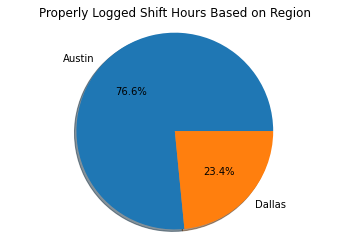

In [11]:
#Visualization 1: proportion of hrs worked per region

driver_region = filtered_df.drop_duplicates(['driverShiftId'])
driver_region = driver_region[['region','driver']]
driver_region['shift'] = shift_elapsed

#set index
ind = [val for val in range(len(driver_region))]
driver_region['ind'] = ind
driver_region = driver_region.set_index('ind')
driver_region

austin_sum = 0
dallas_sum = 0

#sum and plot based on 1. region
for ind in range(len(driver_region)):
    if driver_region['region'][ind] == 'Austin':
        austin_sum += driver_region['shift'][ind]
    elif driver_region['region'][ind] == 'Dallas Fort Worth':
        dallas_sum += driver_region['shift'][ind]

austin_sum = austin_sum / 3600 #685680
austin_sum #190.467 hrs
dallas_sum = dallas_sum / 3600 #214740
dallas_sum #59.65 hrs

hours = np.array([austin_sum, dallas_sum])
region = ["Austin", "Dallas"]

plt.pie(hours, labels=region,
        autopct='%1.1f%%', shadow=True)

plt.title("Properly Logged Shift Hours Based on Region")
plt.axis('equal')
plt.show()

From above we can extend that **the Austin region made up 76.6% of *properly sequenced data*** and outperformed Dallas Fort Worth in properly logging time.

We then move on to visualizing the amount of hours properly logged based on drivers:

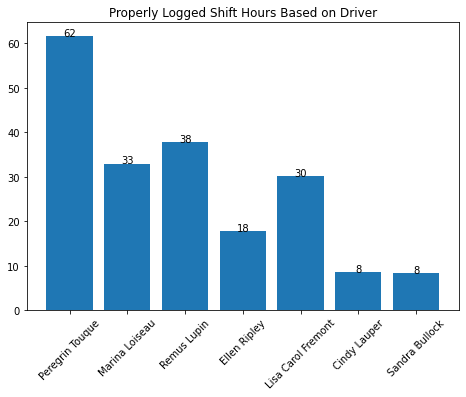

In [12]:
#Visualization 2: proportion of hrs worked per driver

driver_list = driver_region['driver'].unique()
driver_total = []

for driver in driver_list:
    x_df3 = driver_region[driver_region['driver'] == driver] #subset df based on driver
    driver_total.append(round(sum(x_df3['shift']) / 3600, 2))

fig = plt.figure()
hours = np.array(driver_total)
driver = driver_list
ax = fig.add_axes([0,0,1,1])
ax.bar(driver, hours)

# zip joins x and y coordinates in pairs
for x,y in zip(driver,hours):
    label = "{:.0f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,0), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.title("Properly Logged Shift Hours Based on Driver")
plt.xticks(rotation = 45)
plt.show()

From above we see that Peregrin Touque and Remus Lupin have the most properly logged hours which may indicate that they are the most responsible drivers and that **their habits may be highlighted as "bright spots" for other SPs to emulate**.

With driver and regional data explored, we proceed to visualize how Booster Fuel service profession's utilize their shifts:

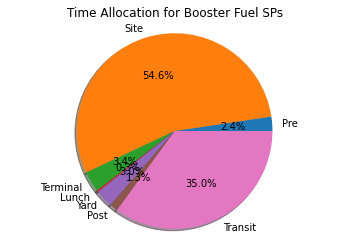

In [13]:
#Visualization 3: time allocation pie chart

hours = np.array([total_pre, total_fleet, total_terminal, total_lunch, total_yard, total_post, total_transit])
states = ["Pre", "Site", "Terminal", "Lunch", "Yard", "Post", "Transit"]

def absolute_value(val):
    a  = np.round(val/100*hours.sum(), 0)
    return a

plt.pie(hours, labels=states,
        autopct='%1.1f%%', shadow=True)

plt.title("Time Allocation for Booster Fuel SPs")
plt.axis('equal')
plt.show()


From the pie chart above we may extend:

* **Site**: time on site / delivering fuel is the single greatest use of time. *We'll further look into the delineation between time on site vs. time delivering fuel.*
* **Transit**: time in transit (between fleet accounts, driving from the yard, etc.) is the second greatest use of time.
* **Remaining States**: only ~10% of remaining time allocation went into pre inspections, post inspections, time at the terminal, time at the yard, and having lunch COMBINED. As such, we may label these states / activities as minor uses of time.

And now as a bar chart with the difference between time on site and delivering fuel highlighted:

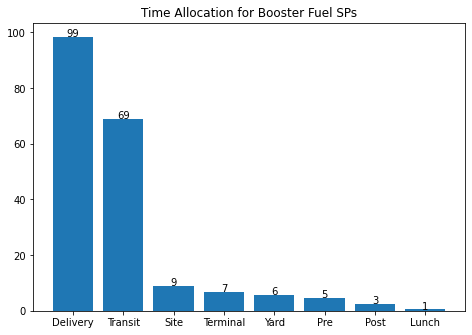

In [14]:
#Visualization 4: time allocation bar chart

total_fleet = total_fleet - total_delivery

fig = plt.figure()
hours = np.array([total_delivery, total_transit, total_fleet, total_terminal, total_yard, total_pre, total_post, total_lunch])
states = ["Delivery", "Transit", "Site", "Terminal", "Yard", "Pre", "Post", "Lunch"]
ax = fig.add_axes([0,0,1,1])
ax.bar(states, hours)

# zip joins x and y coordinates in pairs
for x,y in zip(states,hours):
    label = "{:.0f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,0), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.title("Time Allocation for Booster Fuel SPs")
plt.show()

To further highlight the hours spent in each state by Booster Fuel's service professionals, we can consult the above output and observe that we have 2 major uses of time ("Delivery", "Transit"), 6 minor uses of time ("Site", "Terminal", "Yard", "Pre", "Post", "Lunch"), and that time on site (aforementioned as "Site") was further broken down into "Delivery" (time on a fleet account delivering fuel) and "Site" (time on a fleet account, not delivering fuel).

When we dig further into the fact that time on site was the largest single category for time use, we observe that ~92% of the time spent on a fleet site was logged as time spent delivering fuel.

With regard to **major uses of time**:

* The two largest uses of time are clearly "Delivery" - time spent delivering fuel and "Transit" - time spent moving between sites. Given that we may interpret "Delivery" as the bread and butter of Booster Fuel's business, it's likely that we'd want to maximize time spent in this state (delivering fuel / servicing accounts / making $) while minimizing, within reason, time spent in remaining states (ie. "Transit"). 
* When we consider that ~35% percent of SPs time is spent moving between sites and such we see that this would be the single largest area for major improvement. **Reducing time spent in transit could be the single largest opportunity for maximizing time spent in a state of fuel delivery.**

With regard to **minor uses of time**:

* pre and post inspections should be done regularly and so we would disclude these states from our "areas for improvement"
* "Site" and "Yard" time, time spent in inessential, "sitting and waiting" states should be reduced and may lead to more time delivering fuel and maintaining tankers - thus extending the life of a tanker.
* "Terminal" time may be reduced by refueling at the start / end of a shift rather than toward the middle of a shift (where possible)
* "Lunch" / break time took a small time allocation which may make sense when we consider that refueling is performed at night. 


## Conclusion

The purpose of this case study was to offer labor optimization recommendations based on Service Professional activity logs. To identify patterns, learnings, and suggestions to improve the efficiency of Service Professionals at Booster.

### Patterns and Learnings

We succinctly summarize patterns and learnings from above:

* manual entry is a major problem / the dataset is VERY messy. **Only 23/189 entries were entered in sequence.** Filtering / subsetting data is required to better explore and visualize data in its present form. 
* **Austin appears to be outperforming Dallas Fort Worth** in gallons of gasoline delivered and precision of time logging.
* lunch is the least common state while time delivering fuel and in transit are BY FAR where the greatest time is spent. Remaining states make up only ~10% of time allocation 


### Suggestions

We succinctly summarize suggestions from above:

* it might be worth highlighting / **rewarding "bright spot" drivers** (ie. Peregrin Touque) with good time logging habits so that the habit spreads and data at hand better represents field activity.
* "sitting and waiting" states (ie."Site", "Yard") although minor in time allocation hold potential for minimization. **Routinization and clear scheduling can help in minimizing downtime.**
* time at the terminal and corresponding transit to/from may be reduced by **refueling at the start / end of a shift** (where applicable).
* if we want to maximize SPs time spent in a state of delivering fuel (Booster Fuel's business model), we can focus on the single largest use of time outside of delivery (transit) to unlock the most potential. **Reducing time spent in transit could be the single largest opportunity for maximizing time spent in a state of fuel delivery.**

.............................................................................................

In closing, we visit a quote from Peter Drucker: "What gets measured gets managed."

It's of the utmost importance that Service Professionals properly log their time throughout the day and/or that the process is automated so that data can be read in with confidence in its ability to represent reality. The more representative and whole the data that is collected, the more insight we can glean and the more value we can add back into the company.

Quality data in, quality insight out. It starts at the source of data generation.

It's simple, not easy. 